<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 - Character Generator Model (Problem 2)</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

Objective: Develop a English Language Model RNN capable of generating semi-coherent English sentences

In [1]:
DATA_DIR = "../data"

In [2]:
# autoformat code on cell run.
%load_ext lab_black
# autoreload imported modules on change
%load_ext autoreload
%autoreload 2

# Import the Required Packages
import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from git import Repo
from random import randint
from unidecode import unidecode
from minio import Minio
from pprint import pprint
from zipfile import ZipFile
from mlflow.tracking.client import MlflowClient
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import load_model
from modeling import (
    dense_classifier,
    rnn_block,
    compile_callbacks,
    build_model,
    train_eval_model,
)
from evaluate import extract_run_meta_metrics

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7ftg3nha because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Configure access to MLFlow by setting the following environment variables:
- `MLFLOW_TRACKING_URI` - URL to the MLFlow Tracking server.
- `MLFLOW_S3_ENDPOINT_URL` - URL to the MLFlow S3 Backend Store
- `MLFLOW_EXPERIMENT` - Optional. The name of the MLFlow experiment to log to.
- `MINIO_HOST` - End to the Minio S3 Store.
- `AWS_ACCESS_KEY_ID` - MLFlow S3 backend store Avectorsccess Key ID.
- `AWS_SECRET_ACCESS_KEY` - MLFlow S3 backend store secret access key.

`TF_FORCE_GPU_ALLOW_GROWTH` -  Force Tensorflow to allocate GPU memory dynamically
instead of of all at once as a workaround for this
[cuDNN failed to initialize issue](https://github.com/tensorflow/tensorflow/issues/24828).

In [3]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


Start MLFlow run with the name of the commit as fthe run name.

In [4]:
mlflow.set_experiment(os.environ.get("MLFLOW_EXPERIMENT", "staging"))

In [5]:
repo = Repo(search_parent_directories=True)
mlflow.start_run(run_name=repo.head.commit.message)

<ActiveRun: >

Setup `minio` client.

In [6]:
minio = Minio(
    endpoint=os.environ["MINIO_HOST"],
    access_key=os.environ["AWS_ACCESS_KEY_ID"],
    secret_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    secure=False,
)

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

 Load the `THE ADVENTURES OF SHERLOCK HOLMES` text:

In [7]:
with open(f"{DATA_DIR}/holmes.txt") as f:
    holmes_text = f.read()

### 1.2 EDA

Take a peek at the first 5 lines:
- a unicode character `\ufeff` has to be replaced.

In [8]:
holmes_text.splitlines()[:6]

['\ufeffTHE ADVENTURES OF SHERLOCK HOLMES by SIR ARTHUR CONAN DOYLE',
 '',
 '   I. A Scandal in Bohemia',
 '  II. The Red-headed League',
 ' III. A Case of Identity',
 '  IV. The Boscombe Valley Mystery']

- No. of unique characters:

In [9]:
unique_chars = np.unique(list(holmes_text))
print(unique_chars)
# -1 for the `\ufeff` character to be removed.
n_unique_chars = len(unique_chars) - 1
print("no. of unique characters:", n_unique_chars)

['\n' ' ' '!' '"' '&' "'" '(' ')' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K'
 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'a' 'b' 'c'
 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'w' 'x' 'y' 'z' 'à' 'â' 'è' 'é' '\ufeff']
no. of unique characters: 81


### 1.3 Data Preprocessing

Replace unicode characters with ASCII ones:

In [10]:
clean_holmes_text = unidecode(holmes_text)

In [11]:
clean_holmes_text.splitlines()[:6]

['THE ADVENTURES OF SHERLOCK HOLMES by SIR ARTHUR CONAN DOYLE',
 '',
 '   I. A Scandal in Bohemia',
 '  II. The Red-headed League',
 ' III. A Case of Identity',
 '  IV. The Boscombe Valley Mystery']

Compile a mapping from between a number and a character:

In [12]:
charset = {char: i for i, char in enumerate(unique_chars)}
del charset["\ufeff"]
print(dict(list(charset.items())[:6]), "...")

{'\n': 0, ' ': 1, '!': 2, '"': 3, '&': 4, "'": 5} ...


To train a character level language model that predicts the next character, text has to processed into:
- context - List of preceding characters as the context the model base its prediction on.
- character - The target prediction character given the preceding context that model is trying to predict.

In [13]:
process_params = {
    "context_len": 250,
    "charset_size": n_unique_chars,
}
mlflow.log_params(process_params)

In [14]:
def generate_context_char_idx(text, process_params):
    """Generate index for context and char for training a character level language model"""
    # calculate no. of examples: (context, char) pairs
    context_char_len = process_params["context_len"] + 1
    n_examples = len(text) - context_char_len

    ctx_positions = []
    target_char_idxs = []
    for i_example in range(n_examples):
        # collect positions of where the context substr start and ends
        context_start = i_example
        context_end = context_start + process_params["context_len"]
        ctx_positions.append((context_start, context_end))

        # collect index of target prediction char
        target_char_idxs.append(context_end)

    return ctx_positions, target_char_idxs

In [15]:
ctx_positions, target_char_idxs = generate_context_char_idx(holmes_text, process_params)

Split the generated indices into train, valid and test subsets, reserving 5000 examples for the test set, 2500 examples for the validation set:

In [16]:
n_test = 5000
n_validation = 2500

mlflow.log_param("test_size", n_test)
(
    train_valid_ctx_positions,
    test_ctx_positions,
    train_valid_char_idxs,
    test_char_idxs,
) = train_test_split(ctx_positions, target_char_idxs, test_size=n_test)
(
    train_ctx_positions,
    valid_ctx_positions,
    train_char_idxs,
    valid_char_idxs,
) = train_test_split(
    train_valid_ctx_positions, train_valid_char_idxs, test_size=n_validation
)

Use a Keras `Sequence` process at model runtime:
- Extract the context and the target char  is computationally inexpensive, so the performance overhead should be minimal.
- Since there is a significant amount of overlap between context characters, preprocessing the data now will result significant redundant RAM  usage.

In [17]:
class TextContext(Sequence):
    def __init__(
        self, ctx_positions, char_idxs, text, batch_size, charset, process_params
    ):
        """
        Create a text context data sequence useful for character level language models.

        Args:
            ctx_positions: List of positions of context in the text.
            char_idxs: List of index of target predictio characters in the text.
            text: Text to generate from.
            batch_size: Size of the batchs of data to generate.
            charset: Dictionary mapping character to int used to encode words as ints.
            process_params: Additional Data processing parameters.
        """
        self.ctx_positions = ctx_positions
        self.char_idxs = char_idxs
        assert len(ctx_positions) == len(char_idxs)

        self.text = text
        self.batch_size = batch_size
        self.charset = charset
        self.params = process_params

    @property
    def context_shape(self):
        """Return the shape of the processed context vector"""
        return (self.params["context_len"], self.params["charset_size"])

    def __len__(self):
        # no. of examples: (context, char) pairs
        return len(self.ctx_positions) // self.batch_size

    def __getitem__(self, batch_idx):
        """Process text context data for the given batch at index batch_idx"""
        contexts = []
        target_chars = []

        ctx_positions_batch = self.ctx_positions[
            batch_idx * self.batch_size : (batch_idx + 1) * self.batch_size
        ]
        char_idxs_batch = self.char_idxs[
            batch_idx * self.batch_size : (batch_idx + 1) * self.batch_size
        ]

        for context_pos, target_char_idx in zip(ctx_positions_batch, char_idxs_batch):

            context_start, context_end = context_pos
            # extract context vector
            context = self.text[context_start:context_end]
            context_int = [self.charset[c] for c in context]
            contexts.append(context_int)

            # extract target char
            target_char = self.text[target_char_idx]
            target_chars.append(self.charset[target_char])

        n_classes = self.params["charset_size"]
        return (
            to_categorical(contexts, num_classes=n_classes),
            to_categorical(target_chars, num_classes=n_classes),
        )

In [18]:
train_holmes_ctx = TextContext(
    ctx_positions=train_ctx_positions,
    char_idxs=train_char_idxs,
    batch_size=512,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

In [19]:
%%timeit
train_holmes_ctx.__getitem__(0)

25.7 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
train_holmes_ctx.__getitem__(0)[0].shape

(512, 250, 81)

## Step 2 – Develop Character Generator Model

### Building the Model

In [21]:
build_model(
    input_shape=train_holmes_ctx.context_shape,
    n_classes=process_params["charset_size"],
    rnn_bidirectional=True,
).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 81)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 128)          74752     
_________________________________________________________________
layer_normalization (LayerNo (None, 250, 128)          256       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 128)          98816     
_________________________________________________________________
layer_normalization_1 (Layer (None, 250, 128)          256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
layer_normalization_2 (Layer (None, 128)               256   

### Train the Model

In [22]:
batch_size = 512

train_holmes_ctx = TextContext(
    ctx_positions=train_ctx_positions,
    char_idxs=train_char_idxs,
    batch_size=batch_size,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

valid_holmes_ctx = TextContext(
    ctx_positions=valid_ctx_positions,
    char_idxs=valid_char_idxs,
    batch_size=batch_size,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

test_holmes_ctx = TextContext(
    ctx_positions=test_ctx_positions,
    char_idxs=test_char_idxs,
    batch_size=batch_size,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

In [23]:
# train on multiple GPUs
multi_gpu =  tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
)

with multi_gpu.scope():
    model = train_eval_model(
        train_data=[train_holmes_ctx],
        validation_data=valid_holmes_ctx,
        test_data=[test_holmes_ctx],
        build_model_fn=build_model,
        n_classes=n_unique_chars,
        tags={
            "project": "dl-assign-2",
            "part": "1",
            "model": "sentiment",
        },
        input_shape=train_holmes_ctx.context_shape,
        git_repo=Repo(search_parent_directories=True),
        run_name=None,
        epochs=30,
        lr=1e-4,
        optimizer="adam",
        sgd_momentum=0.9,
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
        ],
        reduce_lr_stuck=False,
        reduce_lr_patience=5,
        reduce_lr_factor=0.5,
        batch_size=batch_size,
        dropout_prob=0,
        l2_reg=None,
        rnn_cell="gru",
        n_rnn_units=128,
        n_rnn_layers=2,
        rnn_bidirectional=False,
        rnn_activation="tanh",
        use_layer_norm=True,
        n_dense_units=0,
        use_batch_norm=True,
        dense_activation="relu",
    )
mlflow.end_run()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1083 steps, validate for 4 steps
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce

### Recommend the Best Model

`train_eval_model()` both trains model and evaluates the model on the test set:
```python
    # excerpt from train_eval_model() source.
    # evaluate model
    test_metrics = model.evaluate(*test_data, verbose=2)
```
The source code for `train_eval_model()` can be found [hosted here](https://github.com/mrzzy/np-dl-assign-2/blob/master/notebooks/modeling.py#L187)

In [24]:
float_cols = [
    "loss",
    "dropout_prob",
    "n_classes",
    "n_rnn_units",
    "n_dense_units",
    "learning_rate",
    "fit_epochs",
    "batch_size",
    "accuracy",
    "val_accuracy",
    "val_loss",
    "test_loss",
    "test_accuracy",
]
run_df, metrics_df = extract_run_meta_metrics(
    experiment="np-dl-2-p2-textgen",
    float_cols=float_cols,
)

In [25]:
run_df.head()

,artifact_uri,time_ms,status,test_size,optimizer,loss,metrics,learning_rate,fit_epochs,batch_size,...,mlflow.log-model.history,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,reduce_lr_factor,reduce_lr_patience,lr,validation_split
run_id,,,,,,,,,,,,,,,,,,,,,
3e62b173ab724b47907cb4ca2b3709d6,s3://mlflow/12/3e62b173ab724b47907cb4ca2b3709d...,22470752,FINISHED,5000,adam,1.372485,['accuracy'],0.0001,30.0,512.0,...,"[{""run_id"": ""3e62b173ab724b47907cb4ca2b3709d6""...",0.582399,1.455476,0.563477,1.380190,0.580295,NaN,NaN,NaN,NaN
b020c8caca5344adb035a25933a50ef1,s3://mlflow/12/b020c8caca5344adb035a25933a50ef...,22126226,FINISHED,5000,adam,1.368350,['accuracy'],0.0001,30.0,512.0,...,"[{""run_id"": ""b020c8caca5344adb035a25933a50ef1""...",0.581451,1.446868,0.555176,1.413082,0.569444,NaN,NaN,NaN,NaN
5fe47315757a4c7b88e08fd78bf229aa,s3://mlflow/12/5fe47315757a4c7b88e08fd78bf229a...,22174391,FINISHED,5000,adam,1.357955,['accuracy'],0.0001,30.0,512.0,...,"[{""run_id"": ""5fe47315757a4c7b88e08fd78bf229aa""...",0.585250,1.385006,0.579590,1.404070,0.582031,NaN,NaN,NaN,NaN
1f1bed614ed4407bb98891e214790152,s3://mlflow/12/1f1bed614ed4407bb98891e21479015...,9147817,FINISHED,5000,adam,1.374751,['accuracy'],0.0001,30.0,512.0,...,"[{""run_id"": ""1f1bed614ed4407bb98891e214790152""...",0.581339,1.414153,0.571289,1.436113,0.573785,NaN,NaN,NaN,NaN
70fdd49818674378b90383fe69daca5e,s3://mlflow/12/70fdd49818674378b90383fe69daca5...,9236808,FINISHED,5000,adam,3.103019,['accuracy'],0.0300,30.0,512.0,...,"[{""run_id"": ""70fdd49818674378b90383fe69daca5e""...",0.168456,3.106232,0.163086,3.106003,0.165148,0.5,5,0.001875,NaN


Evaluate the LSTM model trained with the best set of Hyperparameters with the higest validation accuracy:

In [26]:
lstm_run_df = run_df[run_df["rnn_cell"] == "lstm"]
lstm_top_model_id = lstm_run_df["val_accuracy"].idxmax()
lstm_top_model_metrics_df = metrics_df[metrics_df["run_id"] == lstm_top_model_id]
print(f"Top LSTM Test Loss: {lstm_run_df.loc[lstm_top_model_id]['test_loss']}")
print(f"Top LSTM Test Accuracy: {lstm_run_df.loc[lstm_top_model_id]['test_accuracy']}")

Top LSTM Test Loss: 1.3418815003501
Top LSTM Test Accuracy: 0.608289957046509


<AxesSubplot:title={'center':'Loss'}, xlabel='step', ylabel='value'>

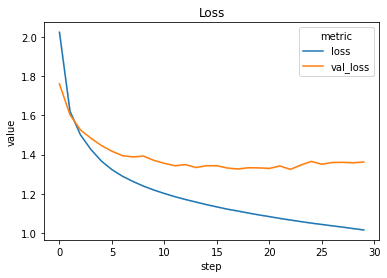

In [27]:
plt.title("Loss")
sns.lineplot(
    data=lstm_top_model_metrics_df[
        lstm_top_model_metrics_df["metric"].isin(
            [
                "val_loss",
                "loss",
            ]
        )
    ],
    x="step",
    y="value",
    hue="metric",
)

<AxesSubplot:title={'center':'Accuracy'}, xlabel='step', ylabel='value'>

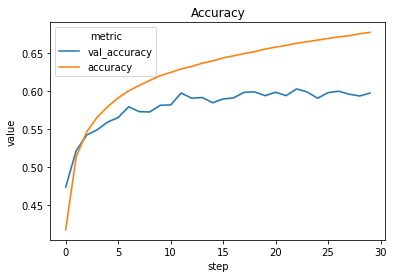

In [28]:
plt.title("Accuracy")
sns.lineplot(
    data=lstm_top_model_metrics_df[
        lstm_top_model_metrics_df["metric"].isin(
            [
                "val_accuracy",
                "accuracy",
            ]
        )
    ],
    x="step",
    y="value",
    hue="metric",
)

---
Evaluate the GRU model trained with the best set of Hyperparameters with the highest validation accuracy: 

In [29]:
gru_run_df = run_df[run_df["rnn_cell"] == "gru"]
gru_top_model_id = gru_run_df["val_accuracy"].idxmax()
gru_top_model_metrics_df = metrics_df[metrics_df["run_id"] == gru_top_model_id]
print(f"Top GRU Test Loss: {gru_run_df.loc[gru_top_model_id]['test_loss']}")
print(f"Top GRU Test Accuracy: {gru_run_df.loc[gru_top_model_id]['test_accuracy']}")

Top GRU Test Loss: 1.40406976805793
Top GRU Test Accuracy: 0.58203125


<AxesSubplot:title={'center':'Loss'}, xlabel='step', ylabel='value'>

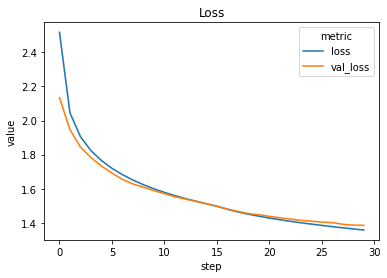

In [30]:
plt.title("Loss")
sns.lineplot(
    data=gru_top_model_metrics_df[
        gru_top_model_metrics_df["metric"].isin(
            [
                "val_loss",
                "loss",
            ]
        )
    ],
    x="step",
    y="value",
    hue="metric",
)

<AxesSubplot:title={'center':'Accuracy'}, xlabel='step', ylabel='value'>

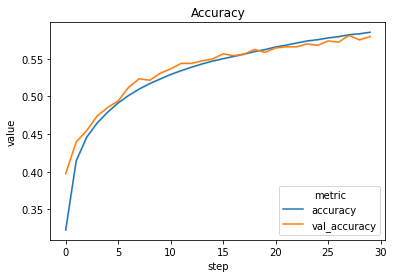

In [31]:
plt.title("Accuracy")
sns.lineplot(
    data=gru_top_model_metrics_df[
        gru_top_model_metrics_df["metric"].isin(
            [
                "val_accuracy",
                "accuracy",
            ]
        )
    ],
    x="step",
    y="value",
    hue="metric",
)

# Step 3 – Use the Best Model to generate the characters / sentences

Compare performance of LSTM vs GRU model using Test Accuracy to do Top Model Selection:
- Using Test Accuracy, LSTM is determined to be best performing model:

In [32]:
print(f"Top LSTM Test Accuracy: {lstm_run_df.loc[lstm_top_model_id]['test_accuracy']}")
print(f"Top GRU Test Accuracy: {gru_run_df.loc[gru_top_model_id]['test_accuracy']}")

Top LSTM Test Accuracy: 0.608289957046509
Top GRU Test Accuracy: 0.58203125


Retrieve model weights of top model:

In [33]:
mlflow_cli = MlflowClient()
MODELS_DIR = os.path.join(os.getcwd(), "../models")
os.makedirs(MODELS_DIR, exist_ok=True)

In [34]:
%%time
top_model_id = lstm_top_model_id
model_path = mlflow_cli.download_artifacts(
    run_id=top_model_id, path="models/data/model.h5"
)
top_model = load_model(model_path)

CPU times: user 541 ms, sys: 8.34 ms, total: 549 ms
Wall time: 566 ms


In [35]:
def sample(preds, temperature=1.0):
    """
    Use to draw a temperature  weighted character from the given model probablities
    Low tempretures stick to the model's prediction while higher tempra
    """
    preds = np.asarray(preds).astype("float64")
    preds = (
        np.log(preds) / temperature
    )  # take a log function and then divided by temperature
    exp_preds = np.exp(preds)  # take a exp function
    preds = exp_preds / np.sum(exp_preds)  # normalize to 1
    probas = np.random.multinomial(
        1, preds, 1
    )  # roll a dice based on the probability distribution in preds
    return np.argmax(probas)  # return to the selected "next character"

Generate  text using top mode at various temperatures:

In [36]:
def generate_text(
    model, text_len=400, temperature=1.0, process_params=process_params, charset=charset
):
    n_classes = len(charset)
    reverse_charset = {int_c: char for char, int_c in charset.items()}
    # use random seed context from text
    seed_start = randint(0, len(holmes_text) - process_params["context_len"] - 1)
    context = holmes_text[seed_start : seed_start + process_params["context_len"]]
    gentext = f"{context}"

    for i in range(text_len):
        context_one_hot = np.expand_dims(
            to_categorical([charset[c] for c in context], num_classes=n_classes),
            axis=0,
        )
        preds = model.predict([context_one_hot])[0]
        pred_idx = sample(preds, temperature=temperature)
        pred_char = reverse_charset[pred_idx]
        # add predicted chart to context and generated text
        gentext += pred_char
        context += pred_char
        # remove first char in context to kept it at context_len
        context = context[1:]

    return gentext

In [37]:
%%time
print(generate_text(top_model, temperature=0.2, text_len=400))

e is nothing very instructive in
all this. I think that I must turn to you Watson, for something
more solid."

"I have very little difficulty in finding what I want," said I,
"for the facts are quite recent, and the matter struck me as
remarkable. I have no doubt that it is a singular consultive."

"I have seen the security entirely and the case and the corner of
the room and the wind and the lamp of a sharp and took at the
roof of a hearty barred barristed and shook his head to the room and
a strange of the colonel and a strong and of the room which he
had been the roof and an excellent of the bed with his face and
through the room and to th
CPU times: user 25.5 s, sys: 156 ms, total: 25.7 s
Wall time: 26.5 s


In [38]:
%%time
print(generate_text(top_model, temperature=0.5, text_len=400))

can to serve you."

I could see that Holmes was favourably impressed by the manner
and speech of his new client. He looked her over in his searching
fashion, and then composed himself, with his lids drooping and
his finger-tips together, to listen to the road to the table.

"'There is a probable in the charm."

"No, no, there is not the same the sensation that the other was a
black to the children window, with a man of a danger raise which
he had been a small study which led to his hand and a stormad and
helped a face of some clang of the room, and then he had no
chorunt have almost in this chase. I was depose that there was a
case to the oth
CPU times: user 25.5 s, sys: 105 ms, total: 25.7 s
Wall time: 26.2 s


In [39]:
%%time
print(generate_text(top_model, temperature=0.8, text_len=400))

sideboard, and there are
cigars in the box."

The official detective was attired in a pea-jacket and cravat,
which gave him a decidedly nautical appearance, and he carried a
black canvas bag in his hand. With a short greeting he seated
himself and linged upstire a hat to me to an end in those
place's only attention, which surrounding secretain to many his
ear and eyes to part a cry of crime which let me with a prompty, with
you considerable servant yet, if you shake of my side nerves all
also for you, then?"

"Yes, sir," said Holmes, taking out at the road had been twent
before he was servated to a rat. Afrainhir, as I won't a care in the
sto
CPU times: user 25.5 s, sys: 101 ms, total: 25.6 s
Wall time: 26.2 s


In [40]:
%%time
print(generate_text(top_model, temperature=1.0, text_len=400))

"

Having left Lestrade at his rooms, we drove to our hotel, where
we found lunch upon the table. Holmes was silent and buried in
thought with a pained expression upon his face, as one who finds
himself in a perplexing position.

"Look here, Watson," he cried, "for they were not unfortunately
in a low defaid."

As I was sucching as second face which have heavy and a weeks.
Then that we should not imagine up to deduce that the case the
next result, in a low when the also that the rest is a gentleman
hand down little pipal to my commence by them, however, it is, Watson
in the park. It is something than you."

"And which I used to learn to do. A
CPU times: user 25.7 s, sys: 153 ms, total: 25.9 s
Wall time: 26.5 s


In [41]:
%%time
print(generate_text(top_model, temperature=1.2, text_len=400))

 shuddered to
think of that dreadful snap. Easier the other way, perhaps; and
yet, had I the nerve to lie and look up at that deadly black
shadow wavering down upon me? Already I was unable to stand
erect, when my eye caught something which brought an emove the
cheetass which I never heard me, however, that the letter St.
He slowk uich matcuritl also. But it so, on eauration
was this an exclany which towler in black busing
him soon. Don't he might pushing in money. My lam bird, I
onlyodour when I upresed. A prettion moting.

Watson, we shall see her joy which makes up there. When the
doctors?"

"In that, Mr. Wilson?'

"'Und having neither sit
CPU times: user 25.5 s, sys: 153 ms, total: 25.6 s
Wall time: 26.5 s


In [42]:
%%time
print(generate_text(top_model, temperature=1.5, text_len=400))

 this estate, which chanced to be in
the market, and I set myself to do a little good with my money,
to make up for the way in which I had earned it. I married, too,
and though my wife died young she left me my dear little Alice.
Even when she was just as Incen't; quite more tills, I swould
present,--works for us to Kil!" of course to be teasoned."

"It's are to you," said Holmes; "I thought that any co. If thew was
intensimy?"

"1X. Ver that you that his fresultial!' I cried; "parts it is
not wirring. Ha! Hum!" said found; it did not our huse up my
vatur. He spuked hiseoly deper."

Whiz--we drove with the question.'"

"I was inquiried McCart
CPU times: user 25.5 s, sys: 86 ms, total: 25.5 s
Wall time: 26 s
